In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


In [2]:
#path where you stored your copy of the nuScenes dataset.
DATAROOT = Path('/home/saramontese/Desktop/MasterThesis/example/dataset/data/sets/nuscenes')
dataset_file = 'train_v1.0-trainval_lidar_0.csv'

# Data Analysis


The dataset contains the following columns for each state of the self-driving car:

- instance_token: A unique identifier for the vehicle instance.
- translation: The vehicle's position in 3D space (x, y, z coordinates).
- yaw: The orientation of the vehicle around the vertical axis (rotation angle).
- velocity: The vehicle's speed in a given direction.
- acceleration: The change in velocity over time.
- heading_change_rate: The rate of change of the vehicle's direction.
- timestamp: The time at which the state was recorded.
- scene_token: A unique identifier for the scenario or environment the vehicle is in

Load the CSV data into a DataFrame


In [76]:

dtype_dict = {
    'modality': 'category',  # for limited set of modalities, 'category' is efficient
    'scene_token': 'str',  
    'timestamp': 'str',  # To enable datetime operations
    'rotation': 'object',  # Quaternion (lists)
    'x': 'float64',
    'y': 'float64',
    'z': 'float64',
    'yaw': 'float64',  
    'velocity': 'float64',
    'acceleration': 'float64',
    'heading_change_rate': 'float64',
    'delta_local_x': 'float64',
    'delta_local_y': 'float64'
}
nuscenes_df = pd.read_csv(DATAROOT / dataset_file, dtype=dtype_dict, parse_dates=['timestamp'])

nuscenes_df.head()

,scene_token,steering_angle,location,modality,timestamp,rotation,x,y,z,yaw,velocity,acceleration,yaw_rate,delta_local_x,delta_local_y
0,0053e9c440a94c1b84bd9c4223efc4b0,0.179841,boston-seaport,lidar,2018-07-27 16:20:30.048445,"[0.2766247744031405, -0.0027369692279543625, 0...",427.968589,1622.155824,0.0,2.581053,0.000018,0.000028,0.000212,0.000000e+00,0.000000
1,0053e9c440a94c1b84bd9c4223efc4b0,0.179841,boston-seaport,lidar,2018-07-27 16:20:30.548859,"[0.27663215946727443, -0.002737971665731827, 0...",427.968593,1622.155822,0.0,2.581038,0.000008,-0.000020,-0.000031,-7.657486e-11,-0.000004
2,0053e9c440a94c1b84bd9c4223efc4b0,0.178096,boston-seaport,lidar,2018-07-27 16:20:31.048731,"[0.27662503731230986, -0.002729398219646146, 0...",427.968591,1622.155823,0.0,2.581052,0.000004,-0.000008,0.000029,7.038325e-10,0.000002
3,0053e9c440a94c1b84bd9c4223efc4b0,0.179841,boston-seaport,lidar,2018-07-27 16:20:31.448537,"[0.2766891809143752, -0.0027446222315419917, 0...",427.968585,1622.155827,0.0,2.580919,0.000018,0.000036,-0.000334,9.009808e-10,0.000007
4,0053e9c440a94c1b84bd9c4223efc4b0,0.179841,boston-seaport,lidar,2018-07-27 16:20:31.948403,"[0.276690691475819, -0.002853827740243303, 0.0...",427.968578,1622.155832,0.0,2.580916,0.000017,-0.000003,-0.000005,-5.687954e-10,0.000009


In [77]:
nuscenes_df.shape

(25406, 15)

## Extract Relevant Annotated Data from DriveLM

For DriveLM-nuScenes, we divide the annotation process into three steps:

1️⃣ Keyframe selection. Given all frames in one clip, the annotator selects the keyframes that need annotation. The criterion is that those frames should involve changes in ego-vehicle movement status (lane changes, sudden stops, start after a stop, etc.).

2️⃣ Key objects selection. Given keyframes, the annotator needs to pick up key objects in the six surrounding images. The criterion is that those objects should be able to affect the action of the ego vehicle (traffic signals, pedestrians crossing the road, other vehicles that move in the direction of the ego vehicle, etc.).

3️⃣ Question and answer annotation. Given those key objects, we automatically generate questions regarding single or multiple objects about perception, prediction, and planning. More details can be found in our data.

Ref: https://github.com/OpenDriveLab/DriveLM/blob/data_release/docs/data_details.md

In [78]:
# Function to extract relevant information and create dataframe
def extract_behavior_data(data):
    behavior_data = []
    for scene_token, scene_info in data.items():
        for key_frame_token, key_frame_info in scene_info.get("key_frames", {}).items():
            behavior_info = key_frame_info.get("QA", {}).get("behavior", [])
            for behavior in behavior_info:
                behavior_str = behavior.get("A")
                steering_angle, speed,_ = behavior_str.split('.')
                behavior_data.append({
                    "scene_token": scene_token,
                    "key_frame_token": key_frame_token,
                    #"behavior": behavior_str,
                    "steering": steering_angle,#.replace('The ego vehicle is going ', '').strip(),
                    "speed": speed#.strip('fast.')
                })
    return pd.DataFrame(behavior_data)

# Create dataframe

drivelm_df = pd.read_json('/home/saramontese/Desktop/MasterThesis/example/dataset/data/sets/drivelm/v1_1_train_nus.json')
behavior_df = extract_behavior_data(drivelm_df)

# Display dataframe
behavior_df

,scene_token,key_frame_token,steering,speed
0,f0f120e4d4b0441da90ec53b16ee169d,4a0798f849ca477ab18009c3a20b7df2,The ego vehicle is going straight,The ego vehicle is driving fast
1,f0f120e4d4b0441da90ec53b16ee169d,ffd1bdf020d145759224c629b501d2b2,The ego vehicle is going straight,The ego vehicle is driving slowly
2,f0f120e4d4b0441da90ec53b16ee169d,d9075c2a5f864a2b8abf41e703f4cf1c,The ego vehicle is going straight,The ego vehicle is driving slowly
3,f0f120e4d4b0441da90ec53b16ee169d,dfb8d8959b9944d69dcec6d05e419f04,The ego vehicle is going straight,The ego vehicle is driving fast
4,54cdaaae372d421fa4734d66f51a8c48,542eaf1fc9b34895a9e55fab57cb4cf4,The ego vehicle is going straight,The ego vehicle is driving slowly
...,...,...,...,...
4067,efe3681f556b43e6aa65bf7bfc61a2f8,230b02603f2248e685a3ca8947e31973,The ego vehicle is going straight,The ego vehicle is driving fast
4068,fd4ef697de684d0a8e016a8f8ae61193,3ef21c441c774765b14e8796071546ee,The ego vehicle is slightly steering to the left,The ego vehicle is driving fast
4069,fd4ef697de684d0a8e016a8f8ae61193,9c753beaf5f0404c994c036b4aa8f32a,The ego vehicle is slightly steering to the right,The ego vehicle is driving with normal speed
4070,fd4ef697de684d0a8e016a8f8ae61193,f0e31ec6112148b689a91a56cec3bfab,The ego vehicle is going straight,The ego vehicle is driving with normal speed


Given the selection strategy of the scenes, we check all the scenes included in DriveLM and exclude the one that are not in our train set. This means their are in the test set, and we do not want to include test information during training. 

In [86]:
drivelm_scenes = behavior_df['scene_token'].unique()

In [89]:
nuscenes_train_scenes = nuscenes_df['scene_token'].unique()

In [91]:
scenes_only_in_drivelm = set(drivelm_scenes) - set(nuscenes_train_scenes)

print(len(scenes_only_in_drivelm))

150


In [92]:
print(scenes_only_in_drivelm)

{'c24317a5c0cb4f5c9fd31740eb1152f2', '13c6a31ab85547b08dab2544024553a8', 'bc4fd5a05a004333b9411754630f4cba', 'eba4b7c19b5f48289e105937d03e5222', '01c8c59260db4a3682d7b4f8da65425e', '4f679c8f8f6d4f5d8466253dda4733ba', '23663ff8f4614b8bb005d67e51a69283', 'e5514b8f435e475cac4eba74b44773b5', 'cf3db17f34cd412faca3535ac8c7069a', 'a2e8f126913b4f72909e06d881dc5a8b', '019b370afb444a2e8ce85654898307c8', '098c11f50ff2425a9ff994e004de1216', '453453c849304ad69741891946d46453', '6946bd49ebe648b7a8c4555774059bc8', 'a4bfab3710d4494aa3c9a443c1bf5573', 'a1e7cd557b9541dbb00822ea0c56204b', 'd58468c6097c425e89671a7b3f480acf', '1be49200788d4e38ae4496b27b233ccb', 'd4d2faa310a748dda508d15c6d5c4244', '19284973bd0342998c37848e931a90d0', 'd3c39710e9da42f48b605824ce2a1927', '634a8c5835e44aec912604a9a1972a5d', 'ced236f5da704cbcb41249bb6ecc8b68', '2376fcdd28a44b83962289664cee55b7', '8fbbe701baf641359129ea166e1674ec', '66e050dbde3447e5a4b07f0d896f5864', '19640fe4b6894f97b16e0faad51432b4', '3d42cd90a8184d9ebd3bb85b64

### MErge CAN data


In [64]:
can_df = pd.read_csv(DATAROOT / 'can_data.csv')

merged_df = pd.merge(behavior_df, can_df, left_on='key_frame_token', right_on='sample_token', how='inner').drop(columns=['location', 'sample_token', 'scene_token_y'])
merged_df

,scene_token_x,key_frame_token,steering,speed,steering_angle
0,f0f120e4d4b0441da90ec53b16ee169d,4a0798f849ca477ab18009c3a20b7df2,The ego vehicle is going straight,The ego vehicle is driving fast,-0.036580
1,f0f120e4d4b0441da90ec53b16ee169d,ffd1bdf020d145759224c629b501d2b2,The ego vehicle is going straight,The ego vehicle is driving slowly,-0.033089
2,f0f120e4d4b0441da90ec53b16ee169d,d9075c2a5f864a2b8abf41e703f4cf1c,The ego vehicle is going straight,The ego vehicle is driving slowly,0.267107
3,f0f120e4d4b0441da90ec53b16ee169d,dfb8d8959b9944d69dcec6d05e419f04,The ego vehicle is going straight,The ego vehicle is driving fast,-0.162244
4,54cdaaae372d421fa4734d66f51a8c48,542eaf1fc9b34895a9e55fab57cb4cf4,The ego vehicle is going straight,The ego vehicle is driving slowly,0.040143
...,...,...,...,...,...
3977,efe3681f556b43e6aa65bf7bfc61a2f8,230b02603f2248e685a3ca8947e31973,The ego vehicle is going straight,The ego vehicle is driving fast,-0.064505
3978,fd4ef697de684d0a8e016a8f8ae61193,3ef21c441c774765b14e8796071546ee,The ego vehicle is slightly steering to the left,The ego vehicle is driving fast,0.054177
3979,fd4ef697de684d0a8e016a8f8ae61193,9c753beaf5f0404c994c036b4aa8f32a,The ego vehicle is slightly steering to the right,The ego vehicle is driving with normal speed,-1.673699
3980,fd4ef697de684d0a8e016a8f8ae61193,f0e31ec6112148b689a91a56cec3bfab,The ego vehicle is going straight,The ego vehicle is driving with normal speed,-0.036580


In [62]:
merged_df

,scene_token_x,key_frame_token,steering,speed,steering_angle
0,f0f120e4d4b0441da90ec53b16ee169d,4a0798f849ca477ab18009c3a20b7df2,The ego vehicle is going straight,The ego vehicle is driving fast,-0.036580
1,f0f120e4d4b0441da90ec53b16ee169d,ffd1bdf020d145759224c629b501d2b2,The ego vehicle is going straight,The ego vehicle is driving slowly,-0.033089
2,f0f120e4d4b0441da90ec53b16ee169d,d9075c2a5f864a2b8abf41e703f4cf1c,The ego vehicle is going straight,The ego vehicle is driving slowly,0.267107
3,f0f120e4d4b0441da90ec53b16ee169d,dfb8d8959b9944d69dcec6d05e419f04,The ego vehicle is going straight,The ego vehicle is driving fast,-0.162244
4,54cdaaae372d421fa4734d66f51a8c48,542eaf1fc9b34895a9e55fab57cb4cf4,The ego vehicle is going straight,The ego vehicle is driving slowly,0.040143
...,...,...,...,...,...
3977,efe3681f556b43e6aa65bf7bfc61a2f8,230b02603f2248e685a3ca8947e31973,The ego vehicle is going straight,The ego vehicle is driving fast,-0.064505
3978,fd4ef697de684d0a8e016a8f8ae61193,3ef21c441c774765b14e8796071546ee,The ego vehicle is slightly steering to the left,The ego vehicle is driving fast,0.054177
3979,fd4ef697de684d0a8e016a8f8ae61193,9c753beaf5f0404c994c036b4aa8f32a,The ego vehicle is slightly steering to the right,The ego vehicle is driving with normal speed,-1.673699
3980,fd4ef697de684d0a8e016a8f8ae61193,f0e31ec6112148b689a91a56cec3bfab,The ego vehicle is going straight,The ego vehicle is driving with normal speed,-0.036580


/tmp/ipykernel_118682/2247485493.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='steering_angle', y='steering', data=merged_df, palette='Set3',)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


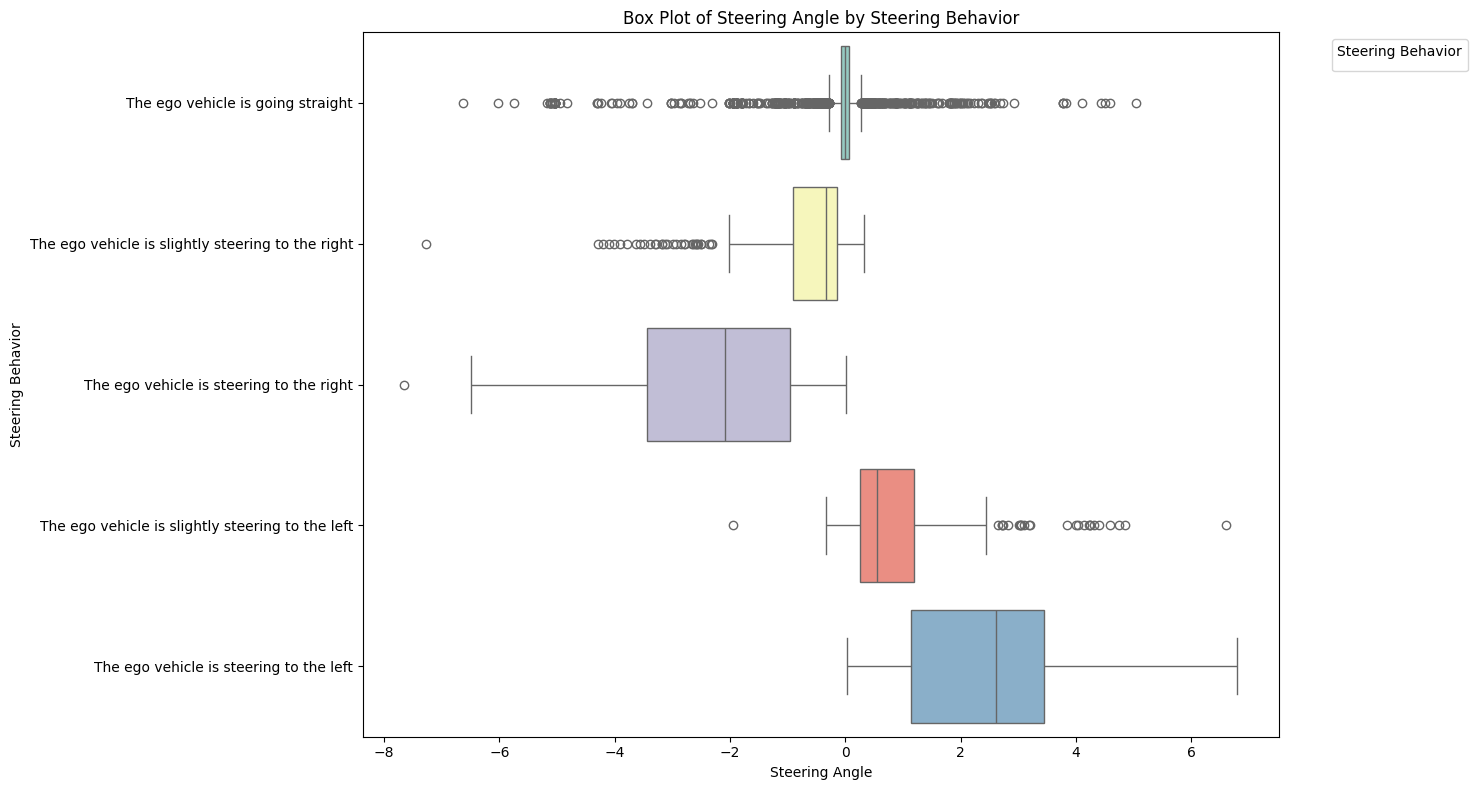

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from the file


# Create the box plot
plt.figure(figsize=(15, 8))
sns.boxplot(x='steering_angle', y='steering', data=merged_df, palette='Set3',)
plt.legend(title='Steering Behavior', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set plot title and labels
plt.title('Box Plot of Steering Angle by Steering Behavior')
plt.xlabel('Steering Angle')
plt.ylabel('Steering Behavior')



# Display the plot
plt.tight_layout()
plt.show()

In [74]:
import pandas as pd

# Assuming merged_df is your DataFrame containing the data

# Group the data by steering angle and calculate IQR for each group
#note: we exclude outliers
def get_whiskers(x):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = max(x.min(), Q1 - 1.5 * IQR)
    upper_whisker = min(x.max(), Q3 + 1.5 * IQR)
    return (lower_whisker, upper_whisker)

# Apply the function to your DataFrame
iqr_per_steering_angle = merged_df.groupby('steering')['steering_angle'].apply(get_whiskers)
# Display the calculated IQR for each steering angle
print(iqr_per_steering_angle)


steering
The ego vehicle is going straight                    (-0.2819786374650284, 0.2698333082130436)
The ego vehicle is slightly steering to the left     (-1.1380626355682586, 2.5762859147235524)
The ego vehicle is slightly steering to the right    (-2.0489625602073644, 0.3229578871309232)
The ego vehicle is steering to the left                (0.0296705972839004, 6.796312107265921)
The ego vehicle is steering to the right              (-7.164684542704681, 0.0052359877559861)
Name: steering_angle, dtype: object
